In [27]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

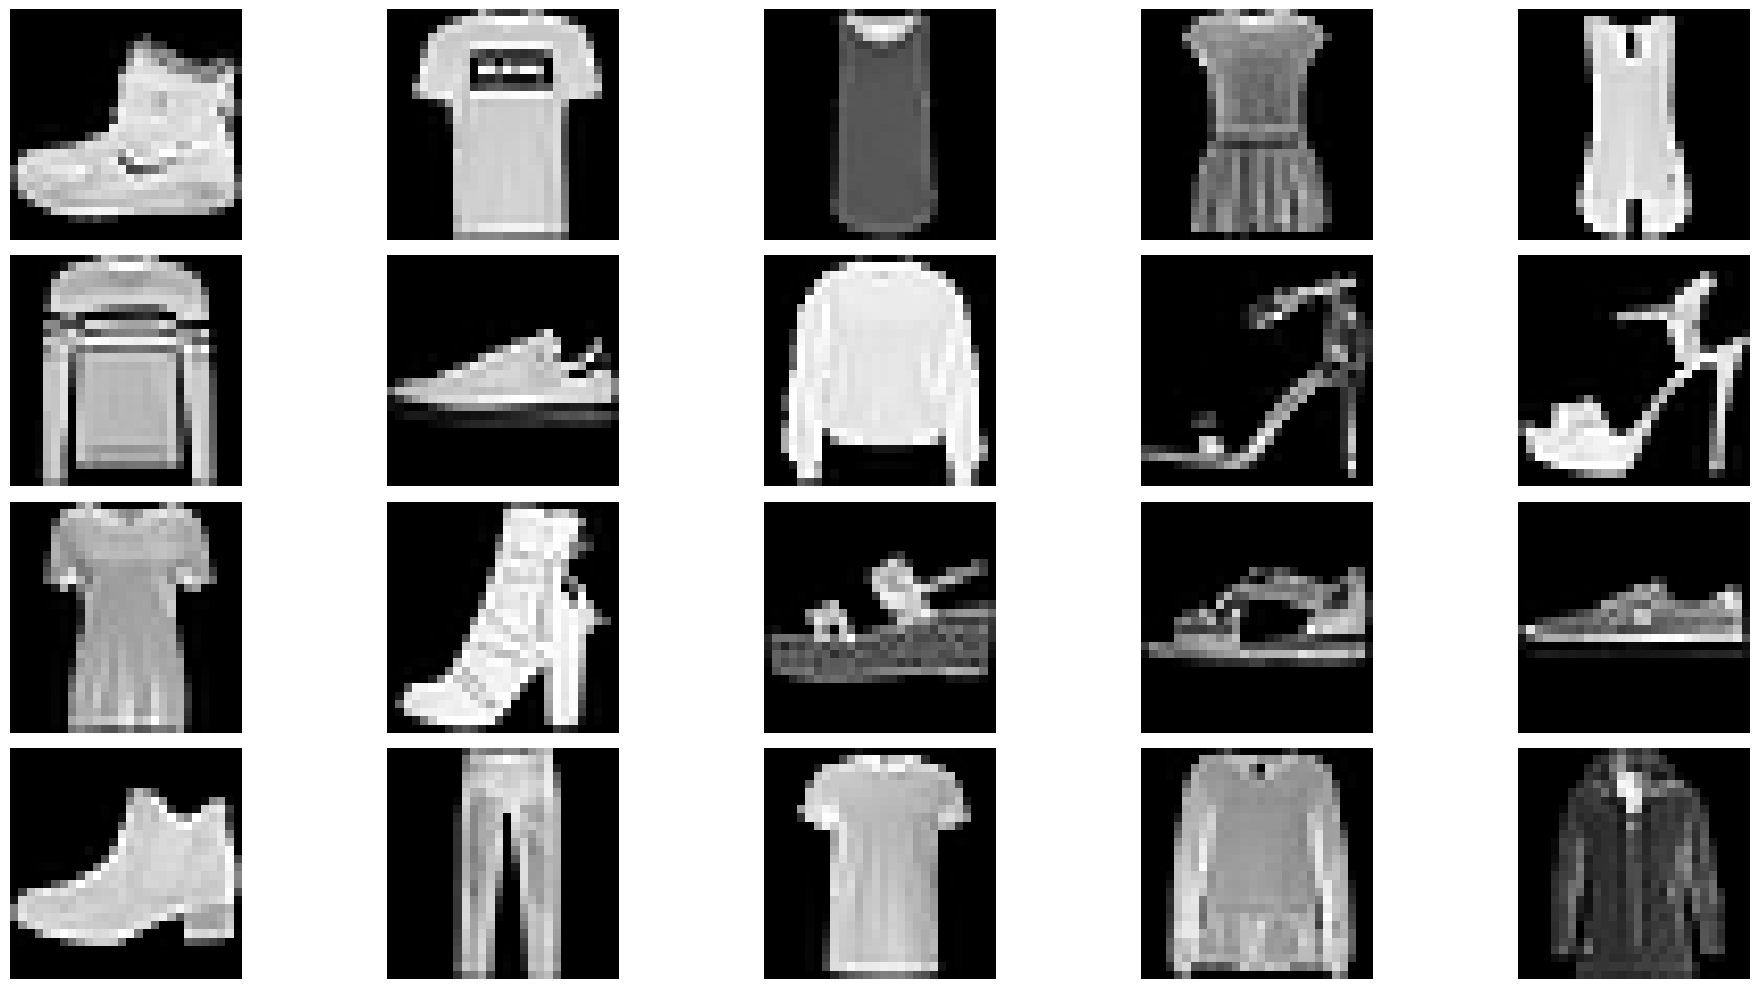

In [28]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [2]:
base_model = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
base_model.summary()

2025-04-03 08:22:40.142279: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-03 08:22:40.142310: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-04-03 08:22:40.142315: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1743661360.142355  606020 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1743661360.142399  606020 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
base_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10


2025-04-03 08:22:59.290144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1719/1719 - 9s - 5ms/step - accuracy: 0.7881 - loss: 0.8110 - val_accuracy: 0.8218 - val_loss: 0.7838
Epoch 2/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8099 - loss: 0.8225 - val_accuracy: 0.8386 - val_loss: 0.6676
Epoch 3/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8154 - loss: 0.8037 - val_accuracy: 0.8288 - val_loss: 0.9336
Epoch 4/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8178 - loss: 0.8121 - val_accuracy: 0.8080 - val_loss: 1.0191
Epoch 5/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8164 - loss: 0.8415 - val_accuracy: 0.8344 - val_loss: 0.8100
Epoch 6/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8218 - loss: 0.8026 - val_accuracy: 0.8130 - val_loss: 1.0090
Epoch 7/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8210 - loss: 0.8396 - val_accuracy: 0.8166 - val_loss: 0.8402
Epoch 8/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8270 - loss: 0.7834 - val_accuracy: 0.8312 - val_loss: 0.7686
Epoch 9/10
1719/1719 - 7s - 4ms/step - accuracy: 0.8280 - loss: 0.7937 - val_accuracy: 0.8070 - val_loss: 0

In [10]:
base_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8009 - loss: 0.9579


[0.9815115332603455, 0.7964000105857849]

In [15]:
model1 = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(5, activation="relu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 5)              │         3,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,985 (15.57 KB)

 Trainable params: 3,985 (15.57 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 10s - 6ms/step - accuracy: 0.5741 - loss: 1.2360 - val_accuracy: 0.6104 - val_loss: 1.0754
Epoch 2/10
1719/1719 - 9s - 5ms/step - accuracy: 0.6132 - loss: 1.1533 - val_accuracy: 0.6154 - val_loss: 1.0336
Epoch 3/10
1719/1719 - 9s - 5ms/step - accuracy: 0.6182 - loss: 1.1752 - val_accuracy: 0.5806 - val_loss: 1.3598
Epoch 4/10
1719/1719 - 8s - 5ms/step - accuracy: 0.6061 - loss: 1.2057 - val_accuracy: 0.6396 - val_loss: 1.1271
Epoch 5/10
1719/1719 - 8s - 5ms/step - accuracy: 0.5912 - loss: 1.3201 - val_accuracy: 0.5480 - val_loss: 1.2918
Epoch 6/10
1719/1719 - 8s - 5ms/step - accuracy: 0.5937 - loss: 1.3543 - val_accuracy: 0.6136 - val_loss: 1.1936
Epoch 7/10
1719/1719 - 8s - 5ms/step - accuracy: 0.5907 - loss: 1.4051 - val_accuracy: 0.6128 - val_loss: 1.3475
Epoch 8/10
1719/1719 - 8s - 5ms/step - accuracy: 0.5898 - loss: 1.4615 - val_accuracy: 0.5724 - val_loss: 1.3936
Epoch 9/10
1719/1719 - 8s - 5ms/step - accuracy: 0.5890 - loss: 1.4676 - val_accuracy: 0.5508 -

In [29]:
model2 = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(64, activation="selu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output_layer"),
                ]
        )
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2, batch_size=32)

Epoch 1/10
1719/1719 - 11s - 6ms/step - accuracy: 0.7796 - loss: 0.6932 - val_accuracy: 0.7954 - val_loss: 0.5871
Epoch 2/10
1719/1719 - 11s - 6ms/step - accuracy: 0.8032 - loss: 0.6518 - val_accuracy: 0.7878 - val_loss: 0.6170
Epoch 3/10
1719/1719 - 10s - 6ms/step - accuracy: 0.8130 - loss: 0.6223 - val_accuracy: 0.8074 - val_loss: 0.6633
Epoch 4/10
1719/1719 - 10s - 6ms/step - accuracy: 0.8119 - loss: 0.6422 - val_accuracy: 0.8332 - val_loss: 0.5858
Epoch 5/10
1719/1719 - 10s - 6ms/step - accuracy: 0.8228 - loss: 0.5922 - val_accuracy: 0.8094 - val_loss: 0.6240
Epoch 6/10
1719/1719 - 11s - 6ms/step - accuracy: 0.8248 - loss: 0.5957 - val_accuracy: 0.8086 - val_loss: 0.6581
Epoch 7/10
1719/1719 - 10s - 6ms/step - accuracy: 0.8269 - loss: 0.6015 - val_accuracy: 0.7628 - val_loss: 0.7475
Epoch 8/10
1719/1719 - 10s - 6ms/step - accuracy: 0.8290 - loss: 0.5819 - val_accuracy: 0.8444 - val_loss: 0.6436
Epoch 9/10
1719/1719 - 11s - 6ms/step - accuracy: 0.8337 - loss: 0.5742 - val_accuracy: 

In [23]:
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7630 - loss: 0.8721


[0.8844945430755615, 0.7621999979019165]

# Autoencoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


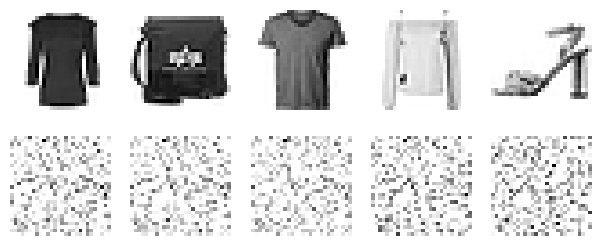

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dense(10, activation="relu"),
                ]
        )
stacked_decoder = keras.Sequential(
        [
                keras.layers.Input(shape=[10]),
                keras.layers.Dense(100, activation="relu"),
                keras.layers.Dense(28 * 28),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(
        loss="binary_crossentropy", optimizer=keras.optimizers.Adam()
        )
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 6s - 14ms/step - loss: 0.6183 - val_loss: 0.5490
Epoch 2/10
430/430 - 4s - 8ms/step - loss: 0.8604 - val_loss: 1.2176
Epoch 3/10
430/430 - 3s - 8ms/step - loss: 1.4216 - val_loss: 1.8367
Epoch 4/10
430/430 - 3s - 8ms/step - loss: 2.2860 - val_loss: 3.0203
Epoch 5/10
430/430 - 4s - 9ms/step - loss: 3.6705 - val_loss: 4.1084
Epoch 6/10
430/430 - 3s - 8ms/step - loss: 4.2761 - val_loss: 4.4361
Epoch 7/10
430/430 - 4s - 9ms/step - loss: 4.4939 - val_loss: 4.5720
Epoch 8/10
430/430 - 3s - 8ms/step - loss: 4.5805 - val_loss: 4.6442
Epoch 9/10
430/430 - 3s - 8ms/step - loss: 4.5872 - val_loss: 4.6255
Epoch 10/10
430/430 - 4s - 9ms/step - loss: 4.6043 - val_loss: 4.6797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


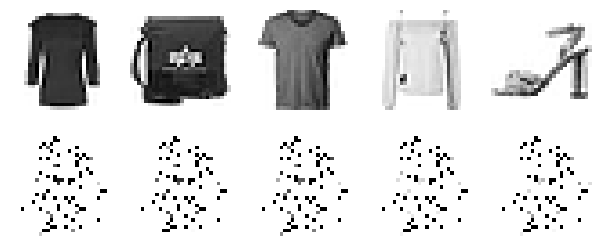

In [7]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
plot_reconstructions(stacked_ae, images=X_valid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


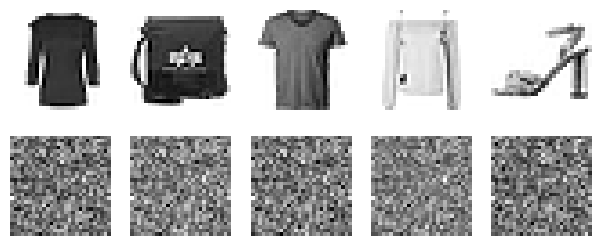

In [20]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


code_size = 9
stacked_encoder = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(14 * 14, activation="selu"),
                keras.layers.Dense(code_size, activation="selu"),
                ]
        )
stacked_decoder = keras.models.Sequential(
        [
                keras.layers.Input(shape=[code_size]),
                keras.layers.Dense(196, activation="selu"),
                keras.layers.Dense(28 * 28, activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
loss = "binary_crossentropy"
stacked_ae.compile(
        loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
        )
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 6s - 14ms/step - loss: 0.4005 - rounded_accuracy: 0.8337 - val_loss: 0.3474 - val_rounded_accuracy: 0.8792
Epoch 2/10
430/430 - 4s - 10ms/step - loss: 0.3382 - rounded_accuracy: 0.8873 - val_loss: 0.3395 - val_rounded_accuracy: 0.8808
Epoch 3/10
430/430 - 4s - 10ms/step - loss: 0.3283 - rounded_accuracy: 0.8950 - val_loss: 0.3269 - val_rounded_accuracy: 0.8955
Epoch 4/10
430/430 - 4s - 10ms/step - loss: 0.3240 - rounded_accuracy: 0.8983 - val_loss: 0.3241 - val_rounded_accuracy: 0.8975
Epoch 5/10
430/430 - 4s - 10ms/step - loss: 0.3212 - rounded_accuracy: 0.9004 - val_loss: 0.3213 - val_rounded_accuracy: 0.9001
Epoch 6/10
430/430 - 4s - 10ms/step - loss: 0.3191 - rounded_accuracy: 0.9021 - val_loss: 0.3221 - val_rounded_accuracy: 0.9026
Epoch 7/10
430/430 - 4s - 10ms/step - loss: 0.3177 - rounded_accuracy: 0.9031 - val_loss: 0.3182 - val_rounded_accuracy: 0.9051
Epoch 8/10
430/430 - 4s - 10ms/step - loss: 0.3164 - rounded_accuracy: 0.9041 - val_loss: 0.3172 - val_r

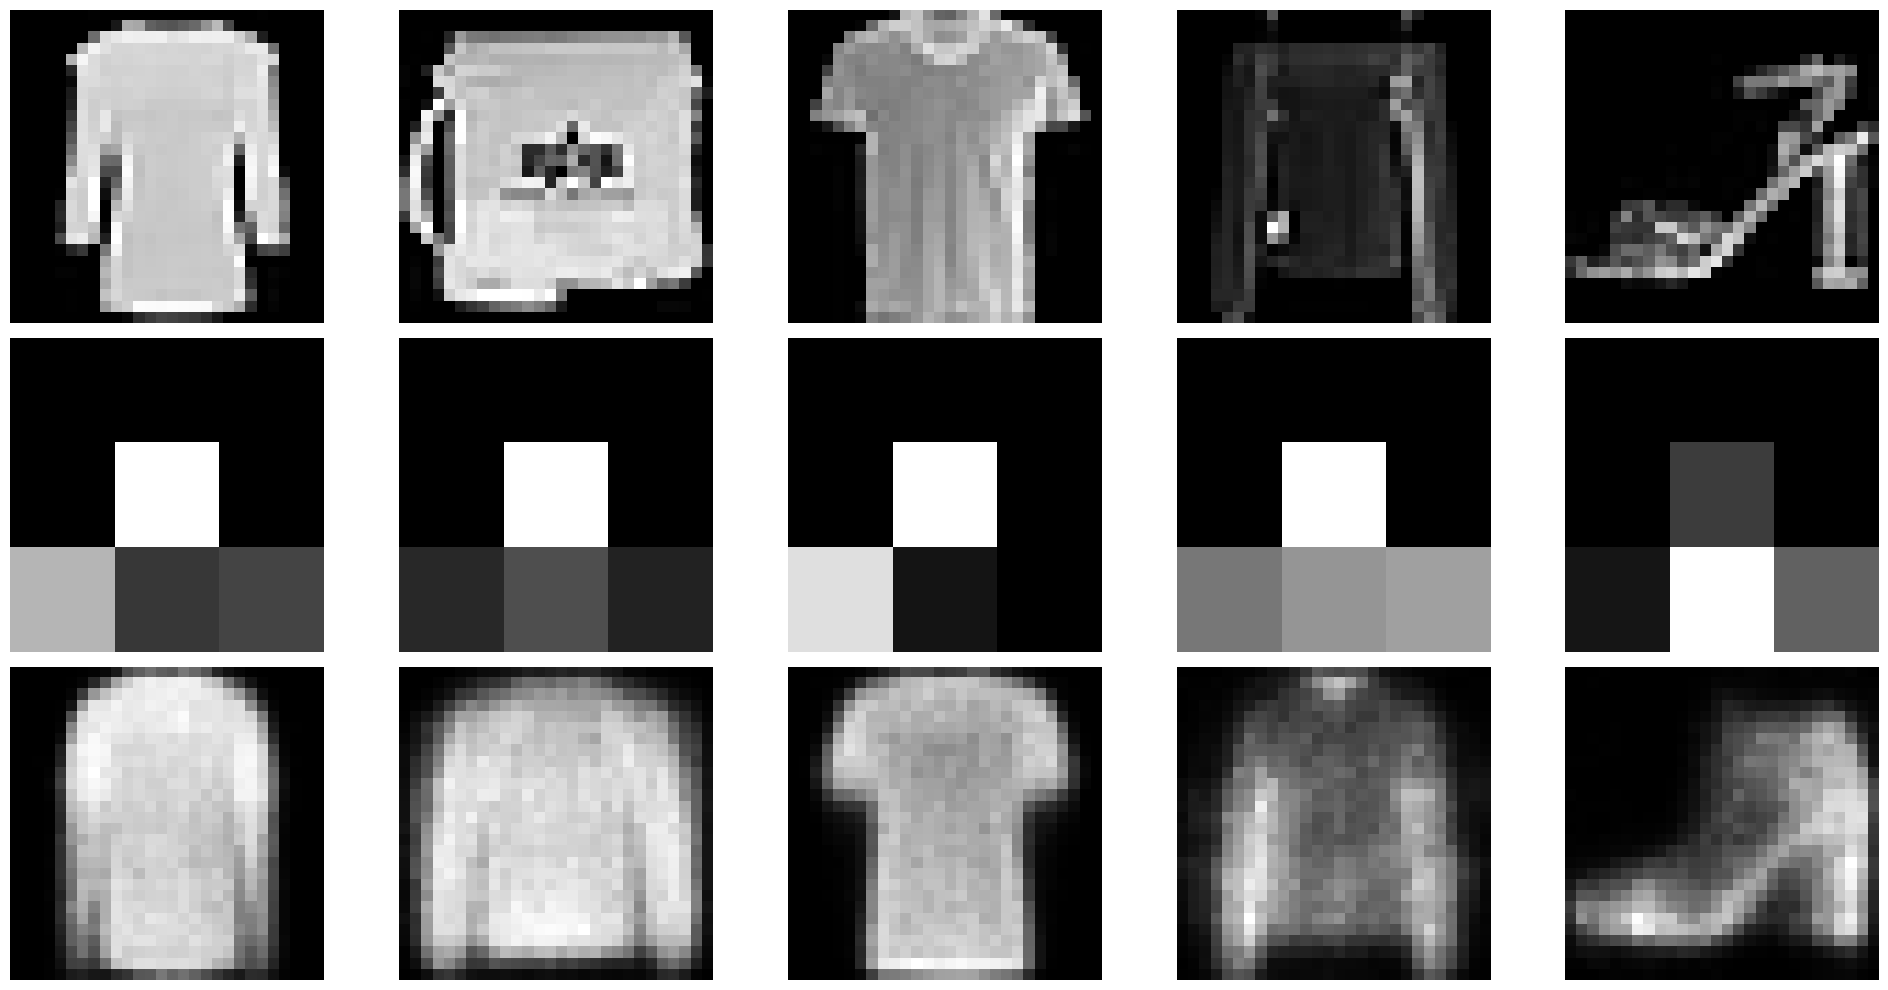

In [21]:
stacked_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(stacked_ae, X_valid, (3, 3), 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


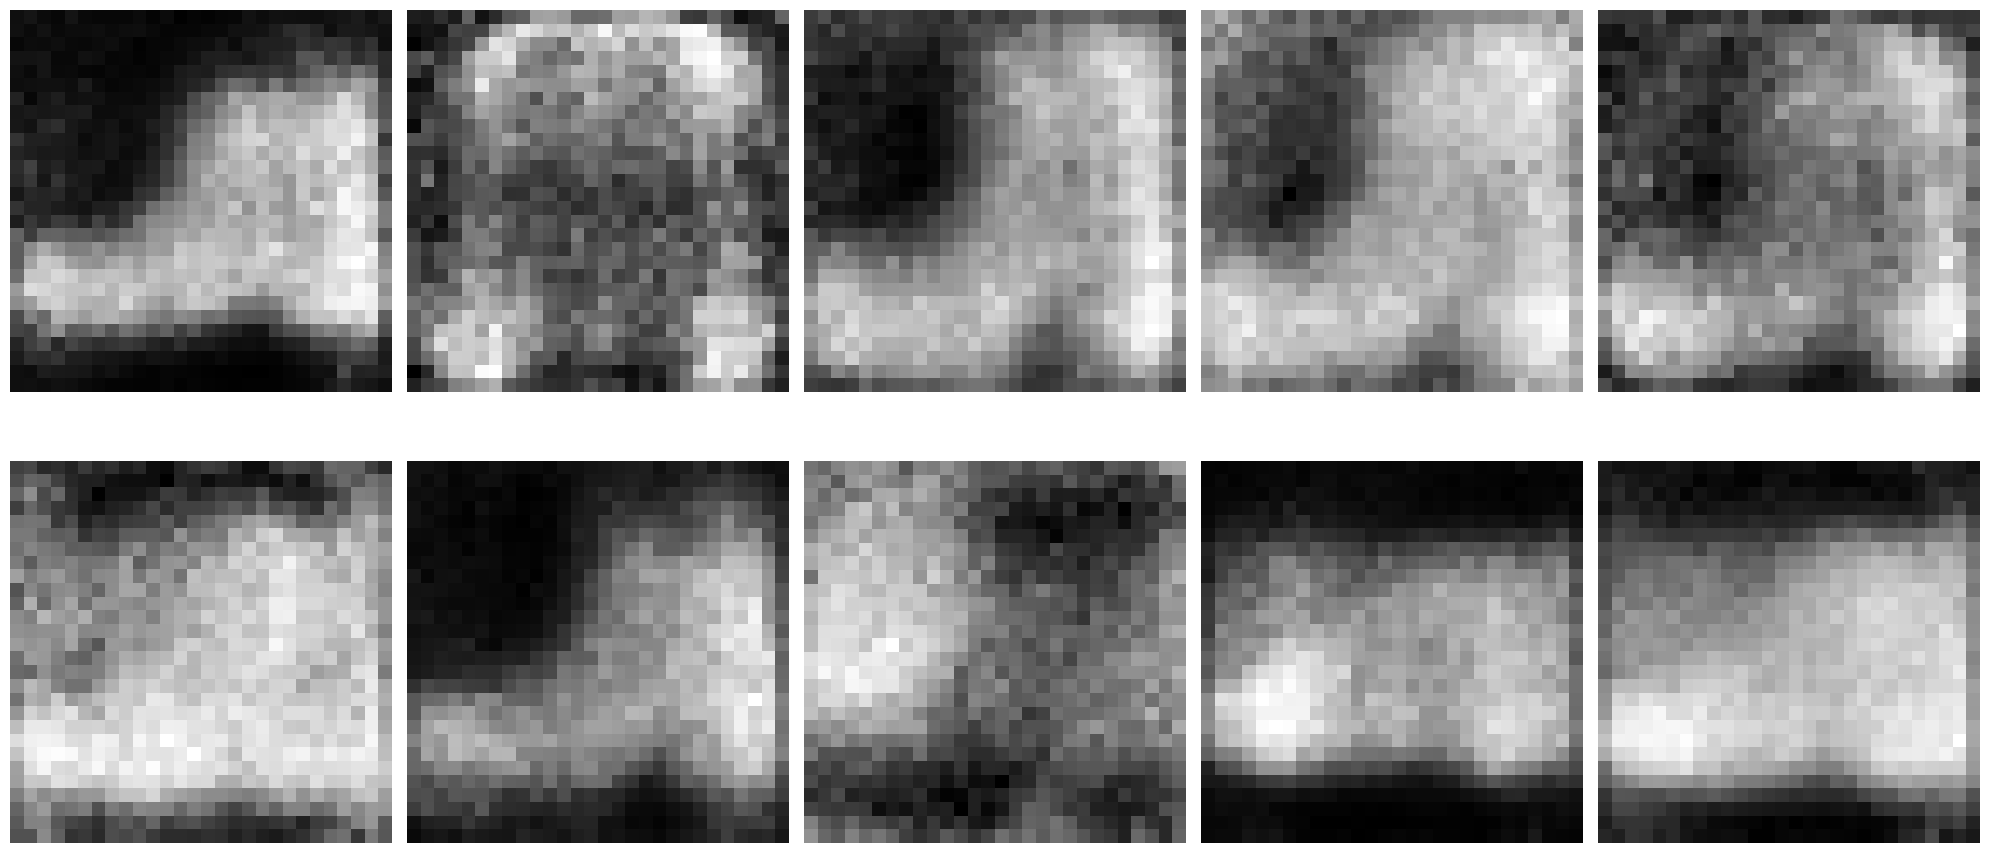

In [34]:
X_code = np.random.normal(size=(10, code_size))
images = stacked_decoder.predict(X_code)
plot_images(images, 2, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


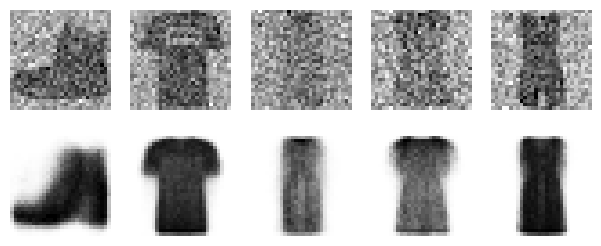

In [37]:
noise = keras.layers.GaussianNoise(0.3)
X_noise = noise(X_train, training=True).numpy()
plot_reconstructions(stacked_ae, images=X_noise[:10])

/Users/thomasbayer/Projects/PycharmProjects/ml/dl_lecture/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/thomasbayer/Projects/PycharmProjects/ml/dl_lecture/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


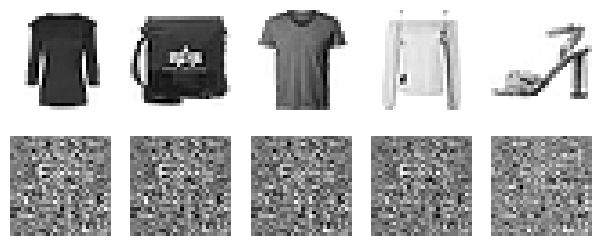

In [38]:
conv_encoder_2 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Reshape([28, 28, 1]),
                keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
                keras.layers.MaxPool2D(pool_size=2),
                keras.layers.Flatten(),
                keras.layers.Dense(code_size)
                ]
        )
conv_decoder_2 = keras.models.Sequential(
        [
                keras.layers.Dense(code_size * 64),
                keras.layers.Reshape([3, 3, 64], input_shape=[3 * 3 * 64]),
                keras.layers.Conv2DTranspose(
                        32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                        input_shape=[3, 3, 64]
                        ),
                keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
                keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
conv_ae_2 = keras.models.Sequential([conv_encoder_2, conv_decoder_2])

conv_ae_2.compile(
        loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
        metrics=[rounded_accuracy]
        )
plot_reconstructions(conv_ae_2, images=X_valid)

In [ ]:
conv_ae_2.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid), verbose=2, batch_size=128)
show_reconstructions_code(conv_ae_2, X_valid, (3, 3), 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


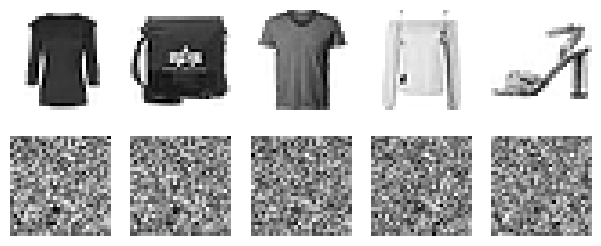

In [35]:
code_size = 64
stacked_encoder1 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(14 * 14, activation="selu"),
                keras.layers.Dense(code_size, activation="selu"),
                ]
        )
stacked_decoder1 = keras.models.Sequential(
        [
                keras.layers.Input(shape=[code_size]),
                keras.layers.Dense(196, activation="selu"),
                keras.layers.Dense(28 * 28, activation="sigmoid"),
                keras.layers.Reshape([28, 28])
                ]
        )
stacked_ae1 = keras.models.Sequential([stacked_encoder1, stacked_decoder1])
loss = "binary_crossentropy"
stacked_ae1.compile(
        loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5)
        )
plot_reconstructions(stacked_ae1, images=X_valid)

Epoch 1/20
430/430 - 4s - 10ms/step - loss: 0.3743 - val_loss: 0.3266
Epoch 2/20
430/430 - 4s - 9ms/step - loss: 0.3185 - val_loss: 0.3149
Epoch 3/20
430/430 - 4s - 9ms/step - loss: 0.3102 - val_loss: 0.3101
Epoch 4/20
430/430 - 4s - 9ms/step - loss: 0.3047 - val_loss: 0.3038
Epoch 5/20
430/430 - 4s - 9ms/step - loss: 0.3007 - val_loss: 0.3002
Epoch 6/20
430/430 - 4s - 9ms/step - loss: 0.2975 - val_loss: 0.2967
Epoch 7/20
430/430 - 4s - 9ms/step - loss: 0.2947 - val_loss: 0.2950
Epoch 8/20
430/430 - 4s - 9ms/step - loss: 0.2924 - val_loss: 0.2935
Epoch 9/20
430/430 - 4s - 9ms/step - loss: 0.2905 - val_loss: 0.2916
Epoch 10/20
430/430 - 4s - 9ms/step - loss: 0.2889 - val_loss: 0.2901
Epoch 11/20
430/430 - 4s - 9ms/step - loss: 0.2876 - val_loss: 0.2888
Epoch 12/20
430/430 - 4s - 9ms/step - loss: 0.2865 - val_loss: 0.2876
Epoch 13/20
430/430 - 4s - 9ms/step - loss: 0.2855 - val_loss: 0.2868
Epoch 14/20
430/430 - 4s - 9ms/step - loss: 0.2847 - val_loss: 0.2862
Epoch 14: early stopping
Res

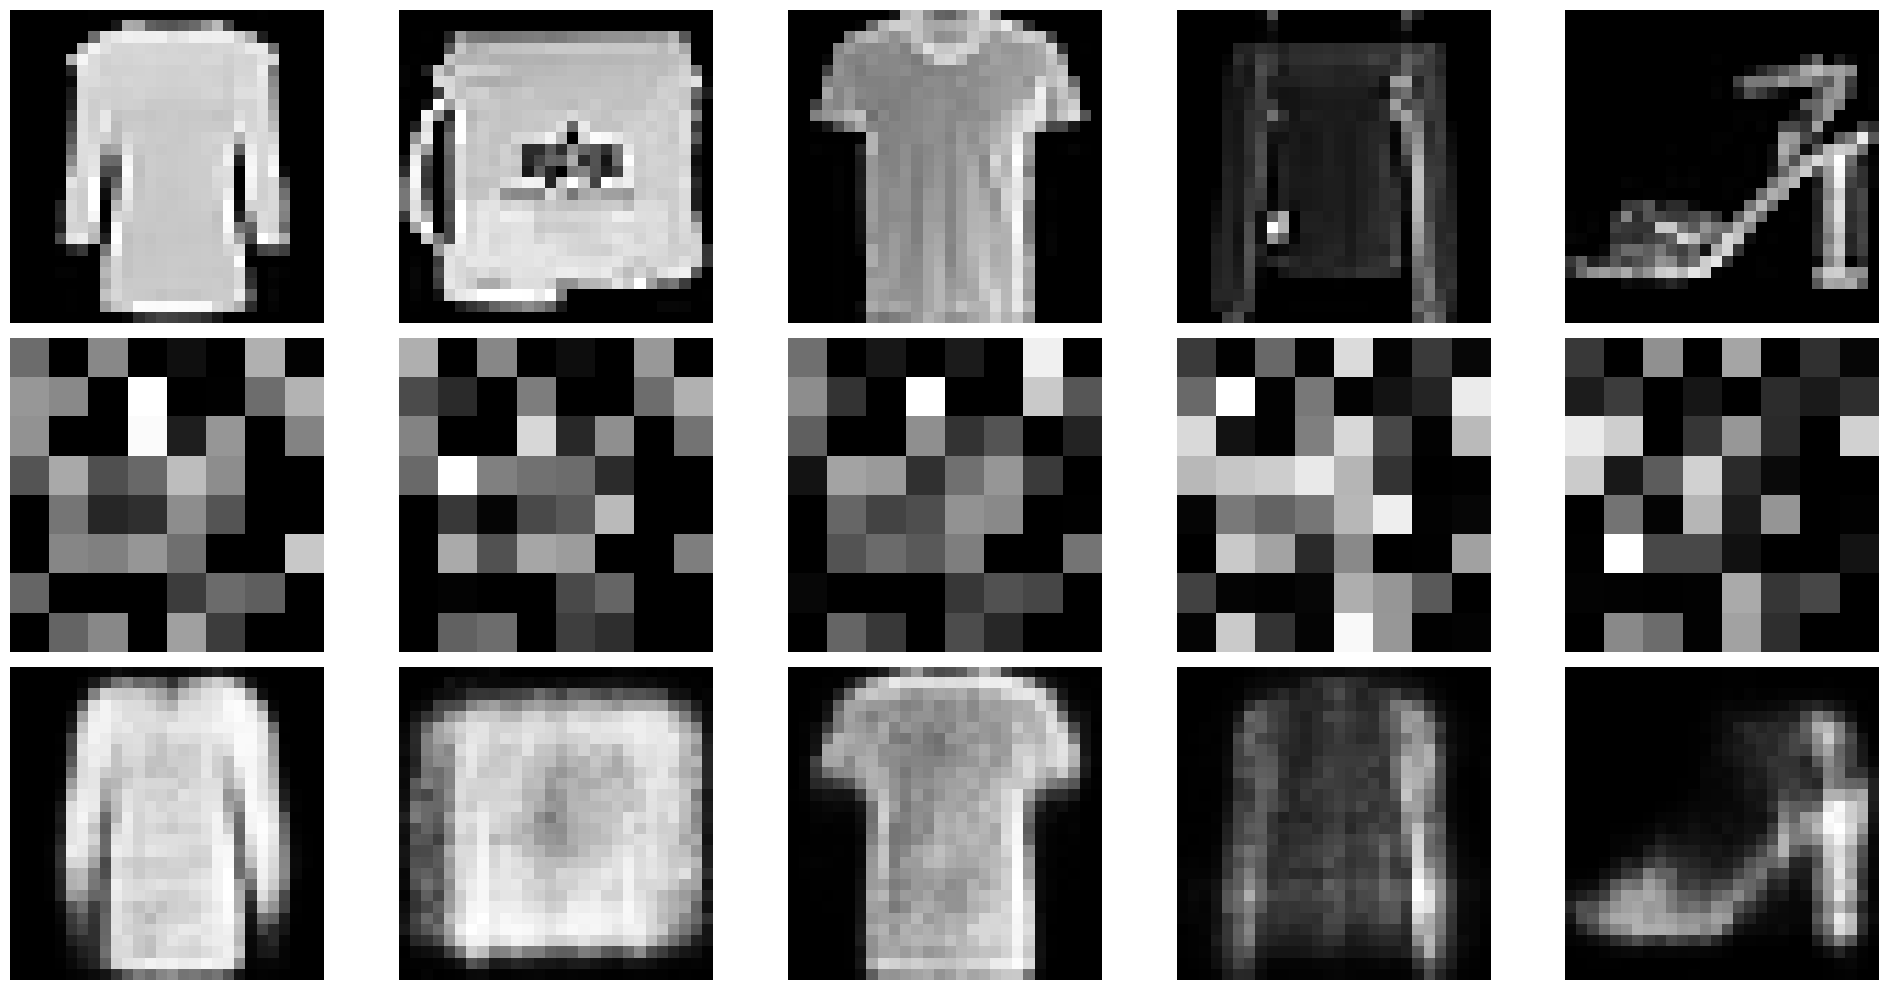

In [36]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=0.002, patience=2,
        mode='auto',
        verbose=True,
        restore_best_weights=True
        )
stacked_ae1.fit(
        X_train, X_train, epochs=20, validation_data=(X_valid, X_valid), verbose=2, batch_size=128,
        callbacks=[early_stopping]
        )
show_reconstructions_code(stacked_ae1, X_valid, (8, 8), 5)


In [38]:
stacked_ae1.save("stacked_ae1.keras")

In [43]:
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = keras.datasets.mnist.load_data()
X_train_digits = tf.cast(mnist_images / 255, tf.float32)
y_train_digits = tf.cast(mnist_labels, tf.int64)


In [46]:
ds = tf.data.Dataset.from_tensor_slices((X_train_digits, y_train_digits))
for x, y in ds.take(2):
    print(f"x.shape: {x.shape}, y: {y.shape}")

x.shape: (28, 28), y: ()
x.shape: (28, 28), y: ()


In [57]:
ds_fashion = tf.data.Dataset.from_tensor_slices((X_train[:10_000], y_train[:10_000]))
ds_negative = ds_fashion.map(lambda x, y: (x, tf.constant(10, tf.int64)))
ds = ds.concatenate(ds_negative)
ds = ds.shuffle(1000).batch(128)

In [58]:
model = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(name="input_layer"),
                keras.layers.Dense(20, activation="relu", name="hidden_layer"),
                keras.layers.Dense(11, activation="softmax", name="output"),
                ]
        )
model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer="adam",
        metrics=["accuracy"]
        )
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 11)             │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,931 (62.23 KB)

 Trainable params: 15,931 (62.23 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.fit(ds, epochs=10, verbose=2)

Epoch 1/10
625/625 - 4s - 6ms/step - accuracy: 0.8656 - loss: 0.4934
Epoch 2/10
625/625 - 3s - 5ms/step - accuracy: 0.9243 - loss: 0.2698
Epoch 3/10
625/625 - 3s - 5ms/step - accuracy: 0.9344 - loss: 0.2355
Epoch 4/10
625/625 - 3s - 5ms/step - accuracy: 0.9381 - loss: 0.2245
Epoch 5/10
625/625 - 3s - 5ms/step - accuracy: 0.9395 - loss: 0.2185
Epoch 6/10
625/625 - 3s - 5ms/step - accuracy: 0.9405 - loss: 0.2143
Epoch 7/10
625/625 - 3s - 5ms/step - accuracy: 0.9417 - loss: 0.2109
Epoch 8/10
625/625 - 3s - 5ms/step - accuracy: 0.9421 - loss: 0.2091
Epoch 9/10
625/625 - 3s - 5ms/step - accuracy: 0.9422 - loss: 0.2085
Epoch 10/10
625/625 - 3s - 5ms/step - accuracy: 0.9426 - loss: 0.2074


In [60]:
model.predict(X_valid[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


array([[1.29767412e-24, 0.00000000e+00, 7.90987583e-21, 1.76121252e-21,
        0.00000000e+00, 4.48273049e-23, 6.04460576e-25, 8.12106876e-33,
        5.81240351e-23, 2.23759205e-31, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.59917144e-37, 1.68497817e-35,
        0.00000000e+00, 2.59886544e-36, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.98223588e-33, 0.00000000e+00, 1.18751110e-30, 1.67175028e-28,
        0.00000000e+00, 2.17714644e-30, 1.84085795e-33, 5.72735231e-32,
        1.02347989e-30, 3.36441027e-38, 1.00000000e+00],
       [8.94342811e-05, 6.84679256e-13, 3.20815889e-05, 7.21846736e-05,
        1.02166797e-09, 2.26802251e-04, 5.26856184e-07, 1.08655698e-08,
        5.44990507e-06, 7.77130271e-09, 9.99573648e-01],
       [3.48450646e-09, 4.99532070e-22, 1.42276972e-08, 1.18726838e-12,
        4.09409646e-22, 2.70850176e-10, 3.70779965e-14, 1.60473859e-16,
        1.75041698e-12, 8.10849637e-19, 1.00000000e+

In [61]:
model.predict(X_train_digits[10:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[2.18865148e-06, 8.16991542e-06, 2.08948375e-04, 9.98237014e-01,
        8.40089498e-10, 2.21548165e-04, 2.51763073e-08, 3.28331055e-07,
        6.36970100e-04, 6.73582428e-04, 1.12055695e-05],
       [1.31983412e-04, 5.12668747e-04, 5.79750631e-03, 3.63625499e-04,
        4.61654086e-03, 8.44822884e-01, 1.27976033e-04, 3.91771891e-07,
        1.24533191e-01, 5.98889642e-07, 1.90927852e-02],
       [2.57005112e-10, 1.62012110e-08, 7.91778405e-07, 9.99984145e-01,
        2.22293729e-11, 1.18049820e-06, 1.29831068e-11, 6.04557338e-09,
        1.39260280e-07, 4.64817268e-10, 1.37633124e-05],
       [8.59801366e-06, 7.74955822e-10, 2.53598369e-03, 2.65978861e-06,
        4.81457449e-04, 2.00983835e-04, 9.93683100e-01, 8.90138718e-09,
        6.86233863e-04, 5.32553677e-05, 2.34770542e-03],
       [2.90589064e-08, 9.95754004e-01, 2.19331007e-04, 7.03640573e-04,
        1.20130906e-07, 8.44064751e-04, 2.24805481e-04, 2.17664328e-05,
        2.17943708e-03, 1.71924930e-05, 3.55260017e-

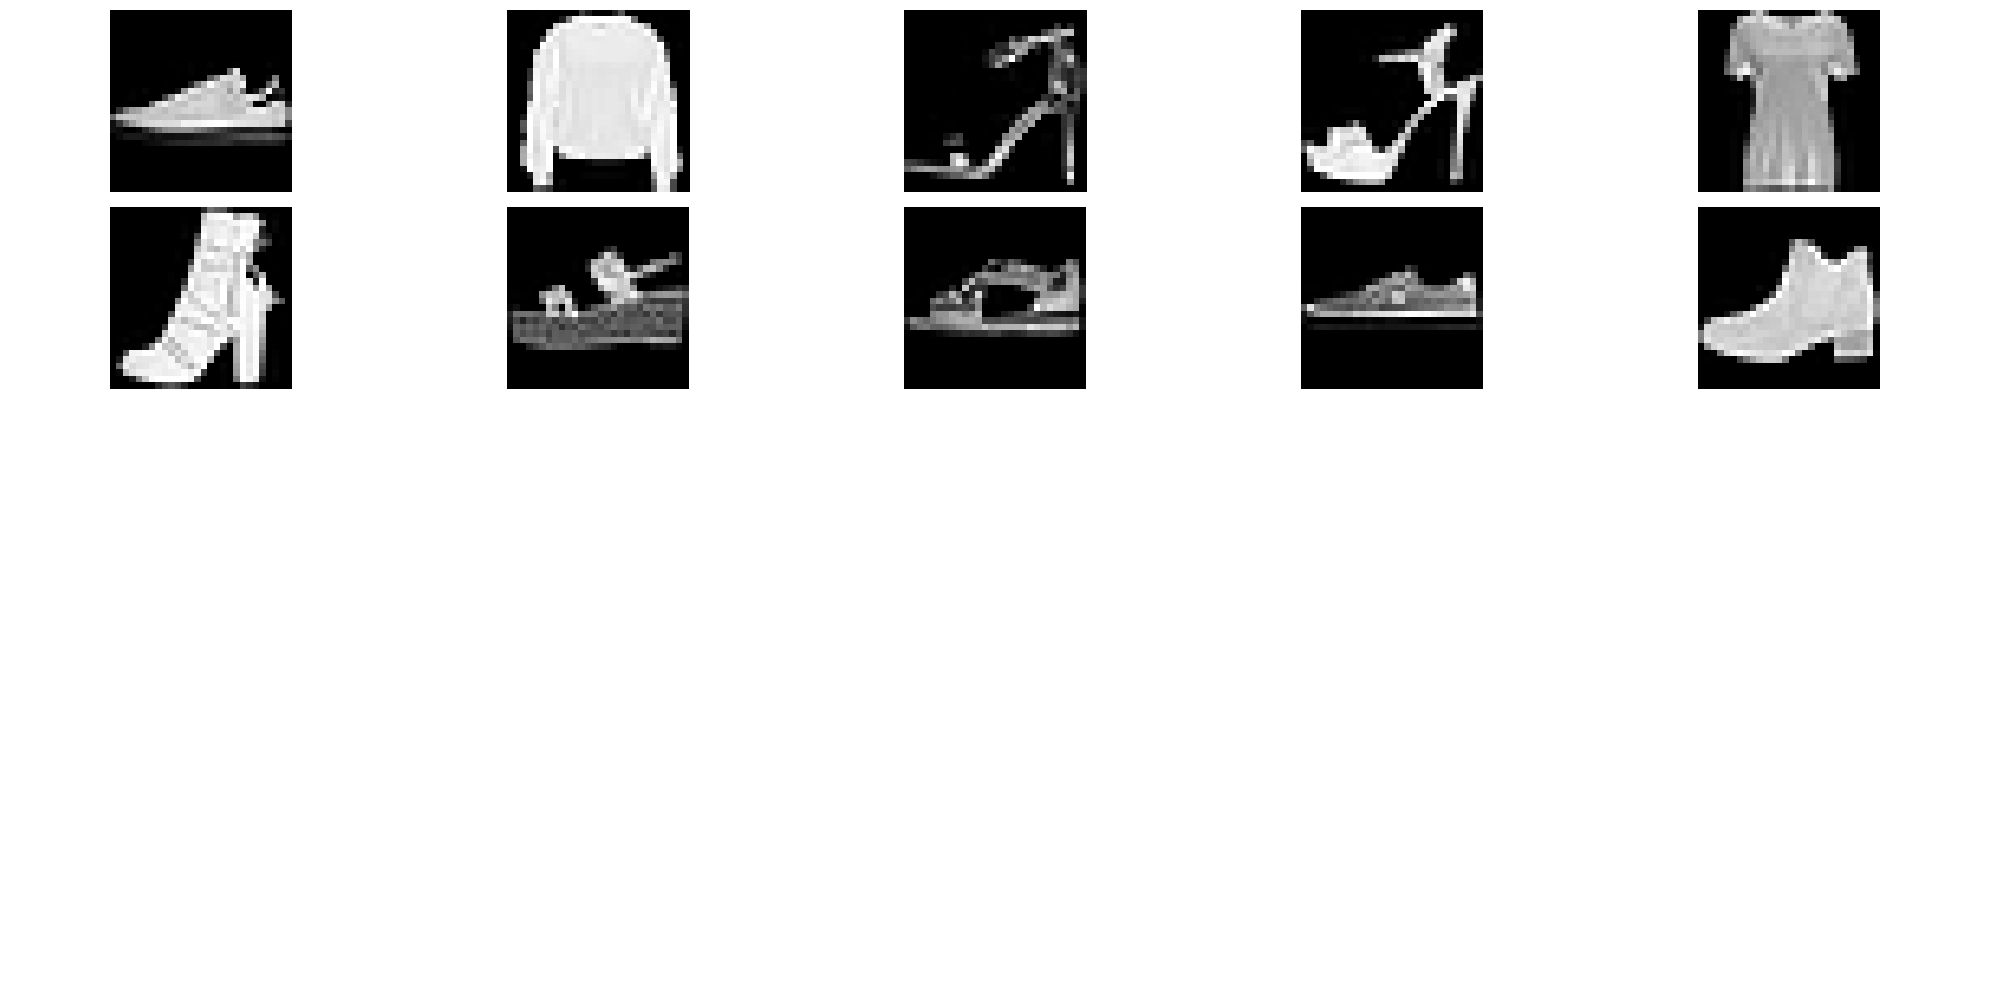

In [11]:
plot_images(X_train[6:16], 5, 5)

In [40]:
from keras.models import load_model

model = load_model("stacked_ae1.keras")

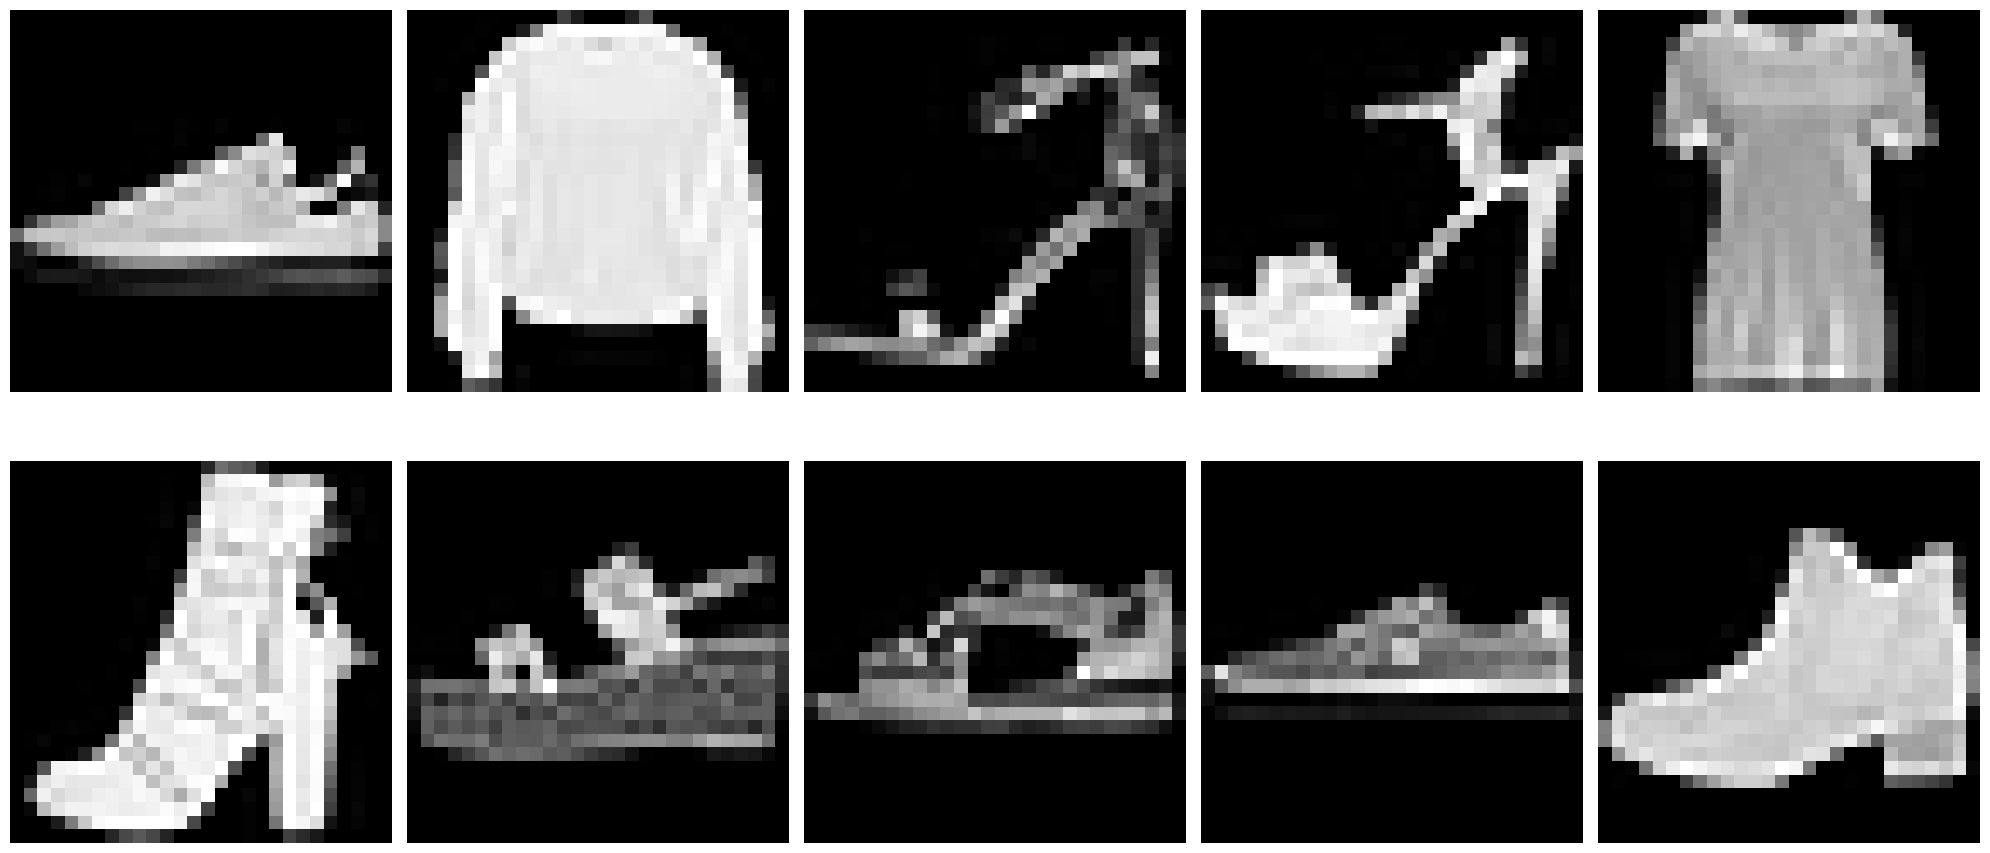

In [42]:
plot_images(X_train[6:16], 2, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(10, 64)
(1, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 28, 28)


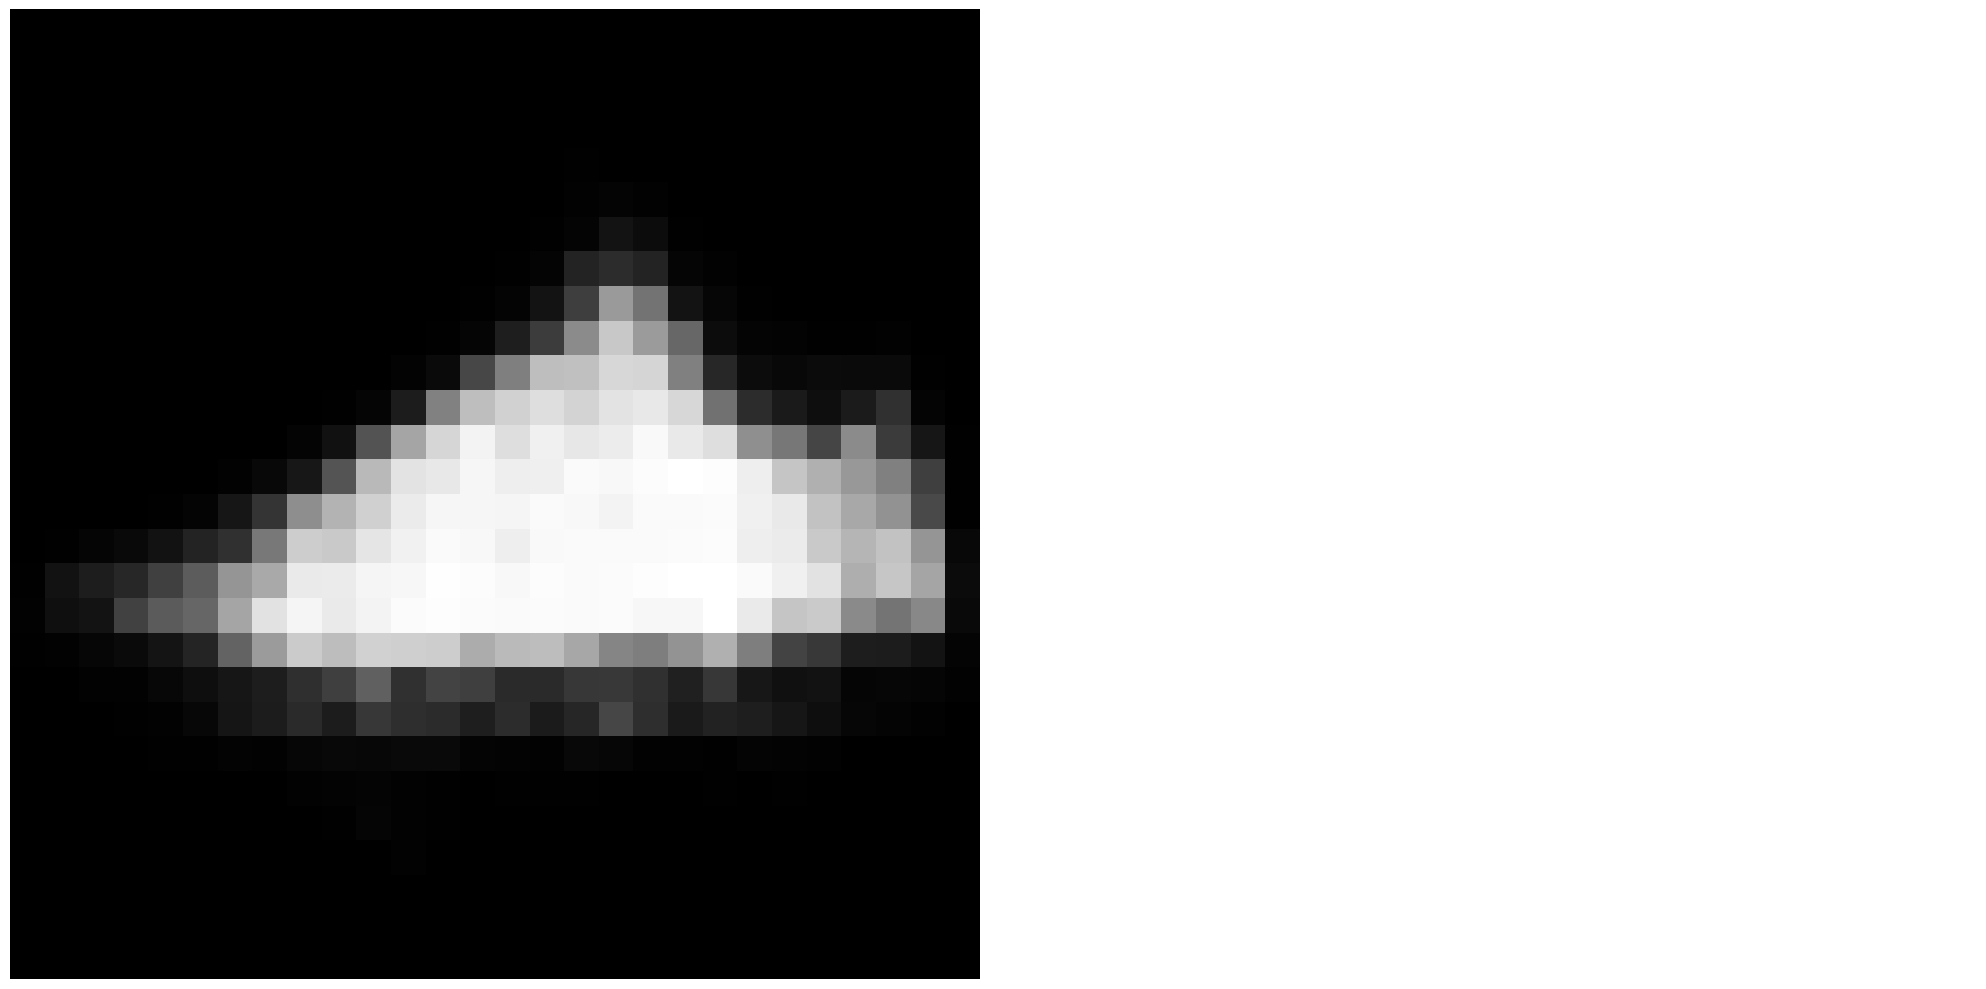

In [50]:
codes = model.layers[0].predict(X_train[6:16])
print(codes.shape)
code = codes[0] + 0.4 * codes[5]
code = code.reshape([1, 64])
print(code.shape)
img = model.layers[1].predict(code)
print(img.shape)
plot_images(img, 1, 2)

In [56]:
A = codes[2]
B = codes[3]
cosine_similarity = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
print(f"Cosine similarity: {cosine_similarity:.5f}")

Cosine similarity: 0.75612
